In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import ADASYN
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (precision_score, classification_report, confusion_matrix, accuracy_score, f1_score, recall_score,)
import matplotlib.pyplot as plt

# Load file
path = '/content/drive/My Drive/ECS171project/ECS171_FINAL_DATASET.csv'
data = pd.read_csv(path)

# Separate features and target
X = data.drop(columns=['Revenue'])
y = data['Revenue']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Class distribution after SMOTE
# print("Class distribution before SMOTE:")
# print(y_train.value_counts())
# print("\nClass distribution after SMOTE:")
# print(pd.Series(y_train_resampled).value_counts())

adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print("Distribution before ADASYN:")
print(y_train.value_counts())
print("\nDistribution after ADASYN:")
print(pd.Series(y_train_resampled).value_counts())

# Training
classification_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
classification_model.fit(X_train, y_train)

# Predictions
y_pred = classification_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

cv_scores = cross_val_score(classification_model, X, y, cv=5)
print(f"\nCross-Validation Scores (Classification): {cv_scores}")
print(f"Mean CV Score (Classification): {cv_scores.mean()}")


Distribution before ADASYN:
Revenue
0    8338
1    1526
Name: count, dtype: int64

Distribution after ADASYN:
Revenue
1    8619
0    8338
Name: count, dtype: int64
Model accuracy: 0.7741281427412814

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2084
           1       0.28      0.28      0.28       382

    accuracy                           0.77      2466
   macro avg       0.57      0.57      0.57      2466
weighted avg       0.78      0.77      0.77      2466


Confusion Matrix:
[[1802  282]
 [ 275  107]]

Cross-Validation Scores (Classification): [0.72262774 0.78183293 0.73317113 0.75182482 0.73195458]
Mean CV Score (Classification): 0.7442822384428224


#Observations:
##Strength:
The model performs well on the majority class (Class 0).
##Weakness:
Performance on the minority class (Class 1) remains poor, with low precision and recall.
Decision trees tend to overfit and may not generalize well to unseen data.
##ADASYN Impact:
Balancing the dataset with ADASYN reduced extreme bias toward Class 0 but did not fully resolve the challenge of identifying Class 1

# Next steps

**Try using a different model**

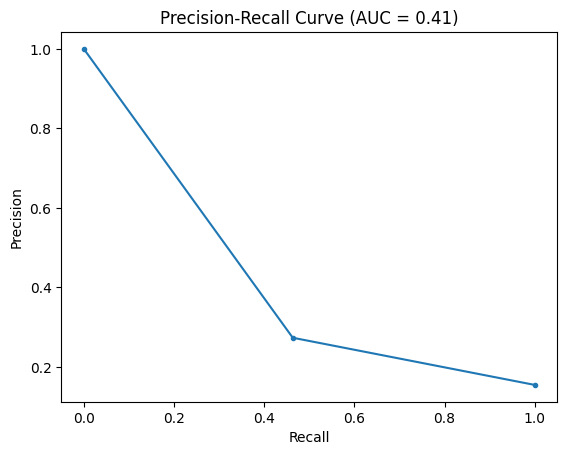

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, classification_model.predict_proba(X_test)[:, 1])
auc_score = auc(recall, precision)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

path = '/content/drive/My Drive/ECS171project/ECS171_FINAL_DATASET.csv'
data = pd.read_csv(path)  # For CSV files

# Splitting
X = data.drop(columns=['Revenue'])
y = data['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train
random_forest_balanced = RandomForestClassifier(random_state=42)
random_forest_balanced.fit(X_resampled, y_resampled)

# Predict
y_pred_balanced = random_forest_balanced.predict(X_test)

# Evaluation
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
report_balanced = classification_report(y_test, y_pred_balanced)

print(f'Accuracy: {accuracy_balanced}')
print('Classification Report:')
print(report_balanced)


Accuracy: 0.7842660178426601
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2055
           1       0.36      0.38      0.37       411

    accuracy                           0.78      2466
   macro avg       0.62      0.62      0.62      2466
weighted avg       0.79      0.78      0.79      2466




### Observations:
1. **Class 0 (majority)**: Still has high precision and recall.
2. **Class 1 (minority)**: Significant improvement in both precision (36%) and recall (38%) compared to the unbalanced model.
3. The overall macro average metrics (precision, recall, and F1-score) have become more balanced.

### Next Steps:
- **Fine-tuning the model**:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Randomized Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform randomized search
random_search.fit(X_resampled, y_resampled)

best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print("Best Parameters:", best_params_random)
print("Best CV Accuracy:", best_score_random)

# Train
best_model = RandomForestClassifier(**best_params_random, random_state=42)
best_model.fit(X_resampled, y_resampled)

# Predict
y_pred_random = best_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred_random)
report = classification_report(y_test, y_pred_random)

print("Test Accuracy:", accuracy)
print("Classification Report:")
print(report)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
Best CV Accuracy: 0.8614796223258038
Test Accuracy: 0.7887266828872669
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2055
           1       0.36      0.35      0.36       411

    accuracy                           0.79      2466
   macro avg       0.62      0.61      0.61      2466
weighted avg       0.79      0.79      0.79      2466




### Observations:
1. **Class 0**:
 - High performance (precision and recall ~87%).
2. **Class 1**:
 - Slight improvement in balance, but still underperforming compared to Class 0. This is expected given the inherent difficulty in predicting the minority class.